#### code reference: https://github.com/TeaPearce/Conditional_Diffusion_MNIST

In [1]:
import os
import csv
import math
import random
import imageio
import argparse
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid

In [2]:
def set_same_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_same_seed(0)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
def csv2list(csv_path):
    gt = []
    with open(csv_path, newline='') as file:
        rows = csv.reader(file)
        for row in rows:
            gt.append(row)
    gt.pop(0)
    return gt

def normolize(x):
    a, b = x.min(), x.max()
    return (x-a)/(b-a)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_csv):
        self.image_dir = image_dir
        self.label_csv = label_csv
        self.data_list = csv2list(label_csv)
        self.data_len = len(self.data_list)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.depth = 3
        self.size = 28
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data_list[idx][0])
        image = Image.open(img_path)
        image = self.transform(image)
        label = torch.tensor(int(self.data_list[idx][1]))    
        return image, label

In [6]:
image_dir = 'hw2_data/digits/mnistm/data/'
train_label_csv = 'hw2_data/digits/mnistm/train.csv'
val_label_csv = 'hw2_data/digits/mnistm/val.csv'

batch_size = 128

In [7]:
train_dataset = ImageDataset(image_dir, train_label_csv)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(image_dir, val_label_csv)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [8]:
images, labels  = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([128, 3, 28, 28])
Labels batch shape: torch.Size([128])


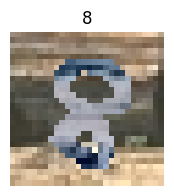

torch.Size([3, 28, 28])


In [9]:
idx = 0
plt.figure(figsize=(2,2))
plt.imshow(images[idx].moveaxis(0, 2))
plt.title(labels[idx].item())
plt.axis('off')
plt.show()
print(images[idx].shape)

In [10]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [11]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

In [12]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {"alpha_t": alpha_t,  # alpha_t
            "oneover_sqrta": oneover_sqrta,  # 1/sqrt{alpha_t}
            "sqrt_beta_t": sqrt_beta_t,  # sqrt{beta_t}
            "alphabar_t": alphabar_t,  # bar{alpha_t}
            "sqrtab": sqrtab,  # sqrt{bar{alpha_t}}
            "sqrtmab": sqrtmab,  # sqrt{1-bar{alpha_t}}
            "mab_over_sqrtmab": mab_over_sqrtmab_inv}  # (1-alpha_t)/sqrt{1-bar{alpha_t}}

In [13]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (self.sqrtab[_ts, None, None, None] * x
               + self.sqrtmab[_ts, None, None, None] * noise)  
        # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts/self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i/self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (self.oneover_sqrta[i] * (x_i - eps*self.mab_over_sqrtmab[i])+ self.sqrt_beta_t[i]*z)
            if i%20==0 or i<8 or i==self.n_T:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [14]:
ddpm = DDPM(nn_model=ContextUnet(in_channels=3, n_feat=128, n_classes=10),
            betas=(1e-4, 0.02), n_T=500, device=device, drop_prob=0.1)
ddpm = torch.load('ddpm.pth')
ddpm.to(device)

DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate=none)
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), st

In [15]:
n_classes = 10
save_dir = 'test2'
ws_test = [0, 0.5, 2]
save_model = False

In [16]:
learning_rate = 1e-4
optimizer = optim.Adam(ddpm.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [17]:
n_epoch = 1000

for e in range(n_epoch):
    print(f'[epoch {e}]')
    batch_num = len(train_dataloader)
    show_num = batch_num//10
    ddpm.train()
    for i, (x, c) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        optimizer.step()
        if i%show_num == 0:
            print(f'[{i:5d}/{batch_num:5d}] train_loss: {loss:4f}')
    scheduler.step()
    print()

[epoch 0]
[    0/  350] train_loss: 1.116533
[   35/  350] train_loss: 0.155691
[   70/  350] train_loss: 0.103960
[  105/  350] train_loss: 0.109439
[  140/  350] train_loss: 0.082646
[  175/  350] train_loss: 0.071963
[  210/  350] train_loss: 0.061227
[  245/  350] train_loss: 0.087211
[  280/  350] train_loss: 0.052078
[  315/  350] train_loss: 0.057186

[epoch 1]
[    0/  350] train_loss: 0.082521
[   35/  350] train_loss: 0.066162
[   70/  350] train_loss: 0.048832
[  105/  350] train_loss: 0.048033
[  140/  350] train_loss: 0.049509
[  175/  350] train_loss: 0.064790
[  210/  350] train_loss: 0.043169
[  245/  350] train_loss: 0.054610
[  280/  350] train_loss: 0.058563
[  315/  350] train_loss: 0.043149

[epoch 2]
[    0/  350] train_loss: 0.046919
[   35/  350] train_loss: 0.042672
[   70/  350] train_loss: 0.062383
[  105/  350] train_loss: 0.033439
[  140/  350] train_loss: 0.043047
[  175/  350] train_loss: 0.038944
[  210/  350] train_loss: 0.043064
[  245/  350] train_los

[  245/  350] train_loss: 0.021184
[  280/  350] train_loss: 0.023524
[  315/  350] train_loss: 0.029717

[epoch 23]
[    0/  350] train_loss: 0.026299
[   35/  350] train_loss: 0.028433
[   70/  350] train_loss: 0.022944
[  105/  350] train_loss: 0.019291
[  140/  350] train_loss: 0.027662
[  175/  350] train_loss: 0.037203
[  210/  350] train_loss: 0.019032
[  245/  350] train_loss: 0.035554
[  280/  350] train_loss: 0.020548
[  315/  350] train_loss: 0.036911

[epoch 24]
[    0/  350] train_loss: 0.026840
[   35/  350] train_loss: 0.028686
[   70/  350] train_loss: 0.035835
[  105/  350] train_loss: 0.029331
[  140/  350] train_loss: 0.031392
[  175/  350] train_loss: 0.026292
[  210/  350] train_loss: 0.029194
[  245/  350] train_loss: 0.030320
[  280/  350] train_loss: 0.019189
[  315/  350] train_loss: 0.015816

[epoch 25]
[    0/  350] train_loss: 0.020961
[   35/  350] train_loss: 0.028712
[   70/  350] train_loss: 0.028996
[  105/  350] train_loss: 0.033553
[  140/  350] train

[  140/  350] train_loss: 0.025354
[  175/  350] train_loss: 0.022240
[  210/  350] train_loss: 0.020012
[  245/  350] train_loss: 0.023758
[  280/  350] train_loss: 0.033451
[  315/  350] train_loss: 0.032782

[epoch 46]
[    0/  350] train_loss: 0.024850
[   35/  350] train_loss: 0.027750
[   70/  350] train_loss: 0.025320
[  105/  350] train_loss: 0.025630
[  140/  350] train_loss: 0.029441
[  175/  350] train_loss: 0.025169
[  210/  350] train_loss: 0.026162
[  245/  350] train_loss: 0.023643
[  280/  350] train_loss: 0.019282
[  315/  350] train_loss: 0.029589

[epoch 47]
[    0/  350] train_loss: 0.024429
[   35/  350] train_loss: 0.025317
[   70/  350] train_loss: 0.031884
[  105/  350] train_loss: 0.027215
[  140/  350] train_loss: 0.026017
[  175/  350] train_loss: 0.022511
[  210/  350] train_loss: 0.025137
[  245/  350] train_loss: 0.023225
[  280/  350] train_loss: 0.019173
[  315/  350] train_loss: 0.021094

[epoch 48]
[    0/  350] train_loss: 0.025007
[   35/  350] train

[   35/  350] train_loss: 0.023285
[   70/  350] train_loss: 0.021082
[  105/  350] train_loss: 0.023221
[  140/  350] train_loss: 0.028898
[  175/  350] train_loss: 0.015755
[  210/  350] train_loss: 0.029747
[  245/  350] train_loss: 0.019974
[  280/  350] train_loss: 0.024286
[  315/  350] train_loss: 0.019047

[epoch 69]
[    0/  350] train_loss: 0.026459
[   35/  350] train_loss: 0.019519
[   70/  350] train_loss: 0.021894
[  105/  350] train_loss: 0.035730
[  140/  350] train_loss: 0.024919
[  175/  350] train_loss: 0.024684
[  210/  350] train_loss: 0.030024
[  245/  350] train_loss: 0.023393
[  280/  350] train_loss: 0.021388
[  315/  350] train_loss: 0.017741

[epoch 70]
[    0/  350] train_loss: 0.022581
[   35/  350] train_loss: 0.026151
[   70/  350] train_loss: 0.017373
[  105/  350] train_loss: 0.021939
[  140/  350] train_loss: 0.025021
[  175/  350] train_loss: 0.021901
[  210/  350] train_loss: 0.026735
[  245/  350] train_loss: 0.032255
[  280/  350] train_loss: 0.033

[  280/  350] train_loss: 0.026512
[  315/  350] train_loss: 0.025047

[epoch 91]
[    0/  350] train_loss: 0.029815
[   35/  350] train_loss: 0.025838
[   70/  350] train_loss: 0.016573
[  105/  350] train_loss: 0.030135
[  140/  350] train_loss: 0.025303
[  175/  350] train_loss: 0.020206
[  210/  350] train_loss: 0.023246
[  245/  350] train_loss: 0.021617
[  280/  350] train_loss: 0.026093
[  315/  350] train_loss: 0.020781

[epoch 92]
[    0/  350] train_loss: 0.029997
[   35/  350] train_loss: 0.019442
[   70/  350] train_loss: 0.024358
[  105/  350] train_loss: 0.023587
[  140/  350] train_loss: 0.021319
[  175/  350] train_loss: 0.018644
[  210/  350] train_loss: 0.022610
[  245/  350] train_loss: 0.018670
[  280/  350] train_loss: 0.020527
[  315/  350] train_loss: 0.016689

[epoch 93]
[    0/  350] train_loss: 0.018742
[   35/  350] train_loss: 0.025315
[   70/  350] train_loss: 0.017544
[  105/  350] train_loss: 0.025897
[  140/  350] train_loss: 0.022968
[  175/  350] train

[  140/  350] train_loss: 0.031670
[  175/  350] train_loss: 0.017537
[  210/  350] train_loss: 0.023469
[  245/  350] train_loss: 0.026072
[  280/  350] train_loss: 0.021521
[  315/  350] train_loss: 0.024699

[epoch 114]
[    0/  350] train_loss: 0.019820
[   35/  350] train_loss: 0.017466
[   70/  350] train_loss: 0.026330
[  105/  350] train_loss: 0.018274
[  140/  350] train_loss: 0.022297
[  175/  350] train_loss: 0.022733
[  210/  350] train_loss: 0.015808
[  245/  350] train_loss: 0.027134
[  280/  350] train_loss: 0.024814
[  315/  350] train_loss: 0.020837

[epoch 115]
[    0/  350] train_loss: 0.018716
[   35/  350] train_loss: 0.016595
[   70/  350] train_loss: 0.020474
[  105/  350] train_loss: 0.021695
[  140/  350] train_loss: 0.017855
[  175/  350] train_loss: 0.024970
[  210/  350] train_loss: 0.025693
[  245/  350] train_loss: 0.023651
[  280/  350] train_loss: 0.020511
[  315/  350] train_loss: 0.027218

[epoch 116]
[    0/  350] train_loss: 0.017242
[   35/  350] tr


[epoch 136]
[    0/  350] train_loss: 0.019000
[   35/  350] train_loss: 0.022724
[   70/  350] train_loss: 0.024778
[  105/  350] train_loss: 0.015239
[  140/  350] train_loss: 0.026667
[  175/  350] train_loss: 0.023356
[  210/  350] train_loss: 0.019208
[  245/  350] train_loss: 0.017694
[  280/  350] train_loss: 0.022409
[  315/  350] train_loss: 0.016776

[epoch 137]
[    0/  350] train_loss: 0.020338
[   35/  350] train_loss: 0.023678
[   70/  350] train_loss: 0.025485
[  105/  350] train_loss: 0.021818
[  140/  350] train_loss: 0.022073
[  175/  350] train_loss: 0.021033
[  210/  350] train_loss: 0.025579
[  245/  350] train_loss: 0.015587
[  280/  350] train_loss: 0.023278
[  315/  350] train_loss: 0.022995

[epoch 138]
[    0/  350] train_loss: 0.022410
[   35/  350] train_loss: 0.022674
[   70/  350] train_loss: 0.021889
[  105/  350] train_loss: 0.019615
[  140/  350] train_loss: 0.020000
[  175/  350] train_loss: 0.028366
[  210/  350] train_loss: 0.021359
[  245/  350] tr

[  210/  350] train_loss: 0.028784
[  245/  350] train_loss: 0.024838
[  280/  350] train_loss: 0.016749
[  315/  350] train_loss: 0.027398

[epoch 159]
[    0/  350] train_loss: 0.023033
[   35/  350] train_loss: 0.021464
[   70/  350] train_loss: 0.020431
[  105/  350] train_loss: 0.016699
[  140/  350] train_loss: 0.024676
[  175/  350] train_loss: 0.025730
[  210/  350] train_loss: 0.023972
[  245/  350] train_loss: 0.020158
[  280/  350] train_loss: 0.014745
[  315/  350] train_loss: 0.019822

[epoch 160]
[    0/  350] train_loss: 0.024982
[   35/  350] train_loss: 0.021444
[   70/  350] train_loss: 0.022267
[  105/  350] train_loss: 0.023231
[  140/  350] train_loss: 0.026854
[  175/  350] train_loss: 0.021740
[  210/  350] train_loss: 0.025493
[  245/  350] train_loss: 0.024539
[  280/  350] train_loss: 0.029264
[  315/  350] train_loss: 0.022166

[epoch 161]
[    0/  350] train_loss: 0.019747
[   35/  350] train_loss: 0.029888
[   70/  350] train_loss: 0.030751
[  105/  350] tr

[   70/  350] train_loss: 0.022628
[  105/  350] train_loss: 0.019039
[  140/  350] train_loss: 0.027277
[  175/  350] train_loss: 0.022184
[  210/  350] train_loss: 0.019574
[  245/  350] train_loss: 0.021210
[  280/  350] train_loss: 0.014917
[  315/  350] train_loss: 0.023897

[epoch 182]
[    0/  350] train_loss: 0.016166
[   35/  350] train_loss: 0.025282
[   70/  350] train_loss: 0.015877
[  105/  350] train_loss: 0.024433
[  140/  350] train_loss: 0.014729
[  175/  350] train_loss: 0.021367
[  210/  350] train_loss: 0.022645
[  245/  350] train_loss: 0.023705
[  280/  350] train_loss: 0.026141
[  315/  350] train_loss: 0.018719

[epoch 183]
[    0/  350] train_loss: 0.015955
[   35/  350] train_loss: 0.025794
[   70/  350] train_loss: 0.019118
[  105/  350] train_loss: 0.022449
[  140/  350] train_loss: 0.018158
[  175/  350] train_loss: 0.025961
[  210/  350] train_loss: 0.015550
[  245/  350] train_loss: 0.023344
[  280/  350] train_loss: 0.022603
[  315/  350] train_loss: 0.0

[  280/  350] train_loss: 0.035305
[  315/  350] train_loss: 0.022050

[epoch 204]
[    0/  350] train_loss: 0.021816
[   35/  350] train_loss: 0.018046
[   70/  350] train_loss: 0.017104
[  105/  350] train_loss: 0.019199
[  140/  350] train_loss: 0.028694
[  175/  350] train_loss: 0.018915
[  210/  350] train_loss: 0.020643
[  245/  350] train_loss: 0.028822
[  280/  350] train_loss: 0.029417
[  315/  350] train_loss: 0.023618

[epoch 205]
[    0/  350] train_loss: 0.017794
[   35/  350] train_loss: 0.033193
[   70/  350] train_loss: 0.031798
[  105/  350] train_loss: 0.018654
[  140/  350] train_loss: 0.018773
[  175/  350] train_loss: 0.027024
[  210/  350] train_loss: 0.021905
[  245/  350] train_loss: 0.027617
[  280/  350] train_loss: 0.020974
[  315/  350] train_loss: 0.020959

[epoch 206]
[    0/  350] train_loss: 0.023470
[   35/  350] train_loss: 0.023134
[   70/  350] train_loss: 0.025891
[  105/  350] train_loss: 0.024871
[  140/  350] train_loss: 0.021604
[  175/  350] tr

[  140/  350] train_loss: 0.020635
[  175/  350] train_loss: 0.022075
[  210/  350] train_loss: 0.022461
[  245/  350] train_loss: 0.021870
[  280/  350] train_loss: 0.019456
[  315/  350] train_loss: 0.025539

[epoch 227]
[    0/  350] train_loss: 0.021195
[   35/  350] train_loss: 0.017309
[   70/  350] train_loss: 0.020434
[  105/  350] train_loss: 0.020061
[  140/  350] train_loss: 0.030128
[  175/  350] train_loss: 0.028360
[  210/  350] train_loss: 0.021573
[  245/  350] train_loss: 0.019629
[  280/  350] train_loss: 0.013830
[  315/  350] train_loss: 0.024579

[epoch 228]
[    0/  350] train_loss: 0.022243
[   35/  350] train_loss: 0.026142
[   70/  350] train_loss: 0.026559
[  105/  350] train_loss: 0.026126
[  140/  350] train_loss: 0.020088
[  175/  350] train_loss: 0.018100
[  210/  350] train_loss: 0.020172
[  245/  350] train_loss: 0.024233
[  280/  350] train_loss: 0.021557
[  315/  350] train_loss: 0.025480

[epoch 229]
[    0/  350] train_loss: 0.026915
[   35/  350] tr


[epoch 249]
[    0/  350] train_loss: 0.022587
[   35/  350] train_loss: 0.018899
[   70/  350] train_loss: 0.016914
[  105/  350] train_loss: 0.021801
[  140/  350] train_loss: 0.019442
[  175/  350] train_loss: 0.026248
[  210/  350] train_loss: 0.021156
[  245/  350] train_loss: 0.021493
[  280/  350] train_loss: 0.025879
[  315/  350] train_loss: 0.022785

[epoch 250]
[    0/  350] train_loss: 0.026126
[   35/  350] train_loss: 0.025673
[   70/  350] train_loss: 0.020390
[  105/  350] train_loss: 0.019267
[  140/  350] train_loss: 0.016150
[  175/  350] train_loss: 0.021191
[  210/  350] train_loss: 0.018893
[  245/  350] train_loss: 0.021919
[  280/  350] train_loss: 0.018571
[  315/  350] train_loss: 0.026395

[epoch 251]
[    0/  350] train_loss: 0.016790
[   35/  350] train_loss: 0.028975
[   70/  350] train_loss: 0.017844
[  105/  350] train_loss: 0.026950
[  140/  350] train_loss: 0.019639
[  175/  350] train_loss: 0.021623
[  210/  350] train_loss: 0.021846
[  245/  350] tr

[  210/  350] train_loss: 0.025268
[  245/  350] train_loss: 0.022888
[  280/  350] train_loss: 0.018847
[  315/  350] train_loss: 0.020547

[epoch 272]
[    0/  350] train_loss: 0.018877
[   35/  350] train_loss: 0.016570
[   70/  350] train_loss: 0.014976
[  105/  350] train_loss: 0.020306
[  140/  350] train_loss: 0.028349
[  175/  350] train_loss: 0.016049
[  210/  350] train_loss: 0.018012
[  245/  350] train_loss: 0.020442
[  280/  350] train_loss: 0.020083
[  315/  350] train_loss: 0.029898

[epoch 273]
[    0/  350] train_loss: 0.023821
[   35/  350] train_loss: 0.022153
[   70/  350] train_loss: 0.020874
[  105/  350] train_loss: 0.027181
[  140/  350] train_loss: 0.024189
[  175/  350] train_loss: 0.019035
[  210/  350] train_loss: 0.026840
[  245/  350] train_loss: 0.031962
[  280/  350] train_loss: 0.020036
[  315/  350] train_loss: 0.019610

[epoch 274]
[    0/  350] train_loss: 0.023070
[   35/  350] train_loss: 0.022756
[   70/  350] train_loss: 0.023436
[  105/  350] tr

[   70/  350] train_loss: 0.019567
[  105/  350] train_loss: 0.024225
[  140/  350] train_loss: 0.023693
[  175/  350] train_loss: 0.015679
[  210/  350] train_loss: 0.019077
[  245/  350] train_loss: 0.023397
[  280/  350] train_loss: 0.027532
[  315/  350] train_loss: 0.020220

[epoch 295]
[    0/  350] train_loss: 0.018815
[   35/  350] train_loss: 0.028315
[   70/  350] train_loss: 0.021977
[  105/  350] train_loss: 0.023034
[  140/  350] train_loss: 0.021988
[  175/  350] train_loss: 0.022064
[  210/  350] train_loss: 0.020295
[  245/  350] train_loss: 0.023609
[  280/  350] train_loss: 0.022893
[  315/  350] train_loss: 0.018711

[epoch 296]
[    0/  350] train_loss: 0.021532
[   35/  350] train_loss: 0.019770
[   70/  350] train_loss: 0.019397
[  105/  350] train_loss: 0.019126
[  140/  350] train_loss: 0.019169
[  175/  350] train_loss: 0.019958
[  210/  350] train_loss: 0.022264
[  245/  350] train_loss: 0.020828
[  280/  350] train_loss: 0.023678
[  315/  350] train_loss: 0.0

[  280/  350] train_loss: 0.024907
[  315/  350] train_loss: 0.027514

[epoch 317]
[    0/  350] train_loss: 0.024230
[   35/  350] train_loss: 0.020030
[   70/  350] train_loss: 0.020327
[  105/  350] train_loss: 0.017882
[  140/  350] train_loss: 0.023453
[  175/  350] train_loss: 0.018769
[  210/  350] train_loss: 0.025742
[  245/  350] train_loss: 0.023818
[  280/  350] train_loss: 0.018123
[  315/  350] train_loss: 0.029580

[epoch 318]
[    0/  350] train_loss: 0.019522
[   35/  350] train_loss: 0.032191
[   70/  350] train_loss: 0.022151
[  105/  350] train_loss: 0.021343
[  140/  350] train_loss: 0.017259
[  175/  350] train_loss: 0.019386
[  210/  350] train_loss: 0.020208
[  245/  350] train_loss: 0.016416
[  280/  350] train_loss: 0.016717
[  315/  350] train_loss: 0.019137

[epoch 319]
[    0/  350] train_loss: 0.026115
[   35/  350] train_loss: 0.018903
[   70/  350] train_loss: 0.014378
[  105/  350] train_loss: 0.017544
[  140/  350] train_loss: 0.017055
[  175/  350] tr

KeyboardInterrupt: 

In [ ]:
n_epoch = 200


for e in range(n_epoch):
    print(f'[epoch {e}]')
    ddpm.train()
    pbar = tqdm(train_dataloader)
    for x, c in pbar:
        optimizer.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        pbar.set_description(f"loss: {loss:.4f}")
        optimizer.step()
    scheduler.step()
    
    ddpm.eval()
    
    with torch.no_grad():
        n_sample = 4*n_classes
        for w_i, w in enumerate(ws_test):
            x_gen, x_gen_store = ddpm.sample(n_sample, (3, 28, 28), device, guide_w=w)

            # append some real images at bottom, order by class also
            x_real = torch.Tensor(x_gen.shape).to(device)
            for k in range(n_classes):
                for j in range(int(n_sample/n_classes)):
                    try: 
                        idx = torch.squeeze((c == k).nonzero())[j]
                    except:
                        idx = 0
                    x_real[k+(j*n_classes)] = x[idx]

            x_all = torch.cat([x_gen, x_real])

            grid = make_grid(x_all*-1 + 1, nrow=10)
            save_image(grid, f"{save_dir}/image_ep{e}_w{w}.png")
            print(f"saved image at {save_dir}/image_ep{e}_w{w}.png")
            
            if e%5==0 or e == int(n_epoch-1):
                # create gif of images evolving over time, based on x_gen_store
                fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                def animate_diff(i, x_gen_store):
                    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                    plots = []
                    for row in range(int(n_sample/n_classes)):
                        for col in range(n_classes):
                            axs[row, col].clear()
                            axs[row, col].set_xticks([])
                            axs[row, col].set_yticks([])
                            # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                            plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                    return plots
                ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                ani.save(f"{save_dir}/gif_ep{e}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                print(f"saved image at {save_dir}/gif_ep{e}_w{w}.gif")
    # optionally save model
    if save_model and e == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir + f"model_{e}.pth")
        print('saved model at ' + save_dir + f"model_{e}.pth")

In [29]:
torch.save(ddpm, 'ddpm.pth')

In [165]:
set_same_seed(0)
save_dir = 'Output_folder/'
ddpm.eval()
with torch.no_grad():
    for i in range(10):
        print(i)
        x_gen, x_gen_store = hw_sample(ddpm, 100, (3, 28, 28), device, guide_w=1)
        for j in range(100):
            a = x_gen[j].to('cpu').moveaxis(0, 2).clamp(0, 1).numpy()
            c, idx = j%10, i*10+(j//10)
            plt.imsave(f'{save_dir}/{str(c)}_{str(idx).zfill(3)}.png', a)

0

1ampling timestep 100

2ampling timestep 100

3ampling timestep 100

4ampling timestep 100

5ampling timestep 100

6ampling timestep 100

7ampling timestep 100

8ampling timestep 100

9ampling timestep 100



In [166]:
x_gen_store.shape

(32, 100, 3, 28, 28)

In [168]:
x_gen_store = torch.tensor(x_gen_store).clamp(0,1)
x_gen_store.shape

In [185]:
show = make_grid(x_gen_store[31], nrow=10).moveaxis(0,2)
show.shape

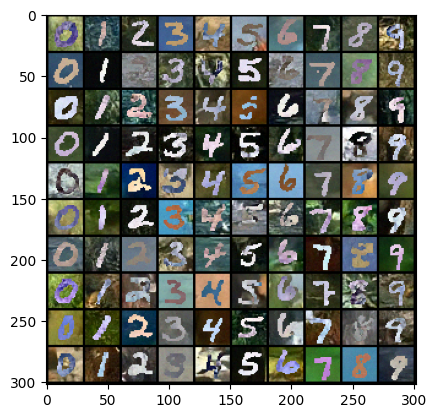

In [187]:
plt.imshow(show)

In [188]:
a = x_gen_store[31]
a.shape

torch.Size([100, 3, 28, 28])

In [189]:
b = torch.zeros_like(x_gen_store[31])
b.shape

torch.Size([100, 3, 28, 28])

In [190]:
for i in range(10):
    for j in range(10):
        b[10*i+j] = a[10*j+i]

In [191]:
b.shape

torch.Size([100, 3, 28, 28])

In [195]:
show = make_grid(b, nrow=10).moveaxis(0,2)
show.shape

torch.Size([302, 302, 3])

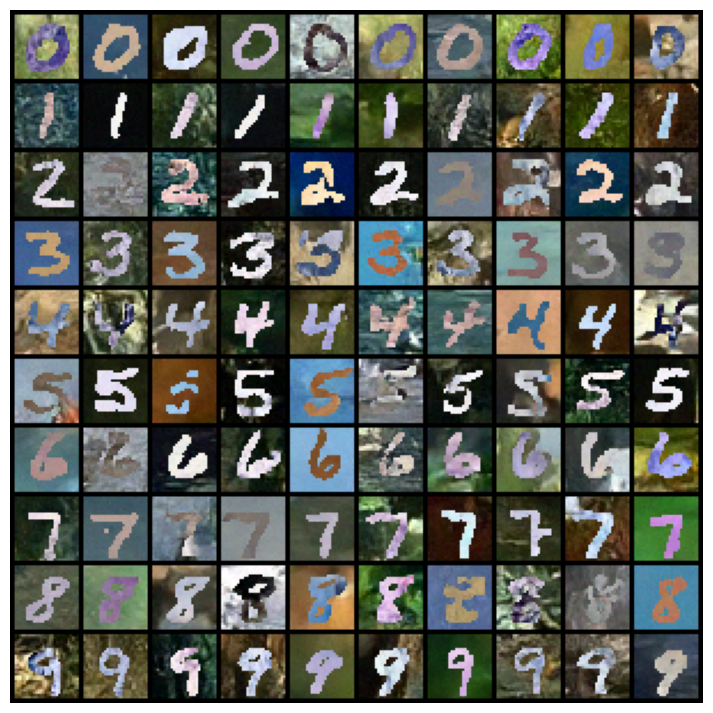

In [196]:
plt.figure(figsize=(9,9))
plt.imshow(show)
plt.axis('off')
plt.show()

In [218]:
sample_t_0 = []
sample_t_0.append(x_gen_store[0,0])
sample_t_0.append(x_gen_store[11,0])
sample_t_0.append(x_gen_store[21,0])
sample_t_0.append(x_gen_store[23,0])
sample_t_0.append(x_gen_store[24,0])
sample_t_0.append(x_gen_store[31,0])

In [219]:
show2 = make_grid(sample_t_0, nrow=6, padding=1)
show2.shape

torch.Size([3, 30, 175])

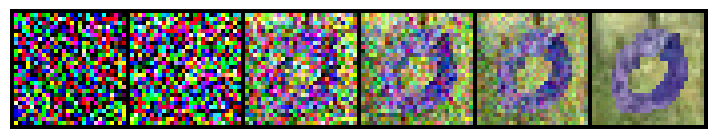

In [220]:
plt.figure(figsize=(9,9))
plt.imshow(show2.moveaxis(0,2))
plt.axis('off')
plt.show()

In [164]:
def hw_sample(model, n_sample, size, device, guide_w = 0.0):

    x_i = torch.randn(n_sample//10, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
    x_i = x_i.repeat(10,1,1,1)  # repeat to make colume noises are the same
    c_i = torch.arange(0, 10).to(device) # context for us just cycles throught the mnist labels
    c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

    # don't drop context at test time
    context_mask = torch.zeros_like(c_i).to(device)

    # double the batch
    c_i = c_i.repeat(2)
    context_mask = context_mask.repeat(2)
    context_mask[n_sample:] = 1. # makes second half of batch context free

    x_i_store = [] # keep track of generated steps in case want to plot something 
    print()

    for i in range(model.n_T, 0, -1):
        print(f'sampling timestep {i}',end='\r')
        t_is = torch.tensor([i/model.n_T]).to(device)
        t_is = t_is.repeat(n_sample,1,1,1)

        # double batch
        x_i = x_i.repeat(2,1,1,1)
        t_is = t_is.repeat(2,1,1,1)

        z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

        # split predictions and compute weighting
        eps = model.nn_model(x_i, c_i, t_is, context_mask)
        eps1 = eps[:n_sample]
        eps2 = eps[n_sample:]
        eps = (1+guide_w)*eps1 - guide_w*eps2
        x_i = x_i[:n_sample]
        x_i = (model.oneover_sqrta[i] * (x_i - eps*model.mab_over_sqrtmab[i])+ model.sqrt_beta_t[i]*z)
        if i%20==0 or i<8 or i==model.n_T:
            x_i_store.append(x_i.detach().cpu().numpy())

    x_i_store = np.array(x_i_store)
    return x_i, x_i_store